# 20220327-zoo-phases
- Phase behavior (per-trace, across simpoints)
    - IPC
    - MPKI
    
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

from utils import utils

In [2]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv'
data_path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_cloudsuite.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

gap = [
    'cc', 'pr', 'sssp', 'bfs', 'tc'
]
spec = [
    'astar', 'bwaves', 'bzip2', 'cactusADM', 'calculix',
    'gcc', 'GemsFDTD', 'hmmer', 'lbm', 'leslie3d',
    'libquantum', 'mcf', 'milc', 'omnetpp', 'soplex',
    'sphinx3', 'tonto', 'wrf', 'xalancbmk'
]
cloudsuite = [
    'cassandra_core0', 'cassandra_core1', 'cassandra_core2', 'cassandra_core3',
    'classification_core0', 'classification_core1', 'classification_core2', 'classification_core3',
    'cloud9_core0', 'cloud9_core1', 'cloud9_core2', 'cloud9_core3',
    'nutch_core0', 'nutch_core1', 'nutch_core2', 'nutch_core3',
    'streaming_core0', 'streaming_core1', 'streaming_core2', 'streaming_core3'
]
    

df = utils.read_data_file(data_path)
df_cs = utils.read_data_file(data_path_cs)
df = df.append(df_cs)
weights = utils.read_weights_file(weight_path)

In [3]:
df

full_trace            trace simpoint    prefetcher  \
0                 astar_163B            astar     163B      bingo_bo   
1                 astar_163B            astar     163B         bingo   
2                 astar_163B            astar     163B  bingo_pythia   
3                 astar_163B            astar     163B    bingo_sisb   
4                 astar_163B            astar     163B     bingo_sms   
...                      ...              ...      ...           ...   
2515  streaming_phase5_core3  streaming_core3   phase5      sisb_spp   
2516  streaming_phase5_core3  streaming_core3   phase5   sisb_pythia   
2517  streaming_phase5_core3  streaming_core3   phase5    sms_pythia   
2518  streaming_phase5_core3  streaming_core3   phase5       sms_spp   
2519  streaming_phase5_core3  streaming_core3   phase5    spp_pythia   

            degree   accuracy   coverage     mpki  mpki_reduction  \
0     (None, None)  15.508980  28.070636  0.98736       50.258942   
1          (None,)  17.140605  28.383891  0.98306       50.475567   
2     (None, None)  18.014248  30.461579  0.95454       51.912343   
3     (None, None)  17.357634  29.317831  0.97024       51.121411   
4     (None, None)  18.815663  32.900603  0.92106       53.598992   
...            ...        ...        ...      ...             ...   
2515  (None, None)  82.580736  22.688697  3.60566       30.387020   
2516  (None, None)  70.138587  42.099824  2.70036       47.865271   
2517  (None, None)  66.272140  44.980724  2.56600       50.459304   
2518  (None, None)  74.733556  37.544759  2.91280       43.763780   
2519  (None, None)  67.244345  35.888606  2.99004       42.272539   

      dram_bw_epochs  dram_bw_reduction      ipc  ipc_improvement  \
0             384334           7.680815  0.53898         7.871510   
1             384481           7.645505  0.53877         7.829481   
2             383159           7.963056  0.54074         8.223757   
3             384047           7.749754  0.53941         7.957570   
4             382615           8.093728  0.54155         8.385870   
...              ...                ...      ...              ...   
2515          945236           1.265677  0.21020         1.301205   
2516          923418           3.544670  0.21526         3.739759   
2517          922487           3.641917  0.21548         3.845783   
2518          929719           2.886501  0.21377         3.021687   
2519          925779           3.298052  0.21470         3.469880   

     baseline_prefetcher                                               path  \
0                     no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
1                     no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
2                     no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
3                     no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
4                     no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
...                  ...                                                ...   
2515                  no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
2516                  no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
2517                  no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
2518                  no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
2519                  no  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   

                                          baseline_path  
0     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
1     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
2     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
3     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
4     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
...                                                 ...  
2515  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
2516  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
2517  /scratch/cluster/c

In [4]:
weights

full_trace    weight            trace simpoint
0                astar_163B  0.452174            astar     163B
1                 astar_23B  0.162319            astar      23B
2                astar_313B  0.220290            astar     313B
3              bwaves_1609B  0.262524           bwaves    1609B
4              bwaves_1861B  0.337187           bwaves    1861B
..                      ...       ...              ...      ...
184  streaming_phase1_core3  0.166667  streaming_core3   phase1
185  streaming_phase2_core3  0.166667  streaming_core3   phase2
186  streaming_phase3_core3  0.166667  streaming_core3   phase3
187  streaming_phase4_core3  0.166666  streaming_core3   phase4
188  streaming_phase5_core3  0.166666  streaming_core3   phase5

[189 rows x 4 columns]

# Helper functions

In [5]:
def get_longest_simpoints(weights):
    idx = (weights.groupby('trace')['weight'].transform(max) == weights['weight'])
    traces = weights[idx].trace
    return traces

def _process_prefetcher(stats, df, weights, tr, pf):
    wt = weights[weights.trace == tr][['simpoint', 'weight']]
    data = df[(df.trace == tr) & (df.prefetcher == pf)]
    data = data.merge(wt, on='simpoint')
    weights = data['weight'] / sum(data['weight'])

    stats['trace'] = np.append(stats['trace'], tr)
    stats['prefetcher'] = np.append(stats['prefetcher'], pf)
    stats['simpoint'] = np.append(stats['simpoint'], 'weighted')
    
    for metric in utils.metrics:
        target = data[metric].item() if len(data) <= 1 else utils.mean(data[metric], metric, weights=weights)
        stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
        
def _process_phase_combined(stats, df, weights, tr):
    wt = weights[(weights.trace == tr)]
    data = df[(df.trace == tr)]
    
    stats['trace'] = np.append(stats['trace'], tr)
    stats['prefetcher'] = np.append(stats['prefetcher'], 'phase_combined')
    stats['simpoint'] = np.append(stats['simpoint'], 'weighted')            
    for metric in utils.metrics:
        best_metrics = data.groupby('simpoint')[metric].max().to_frame()
        best_metrics = best_metrics.merge(wt, on='simpoint')
        best_metrics['weight'] = best_metrics['weight'] / best_metrics['weight'].sum()

        target = utils.mean(best_metrics[metric], metric, weights=best_metrics['weight'])
        stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
    
def get_weighted_statistics(df, weights, metric, add_phase_combined=True):
    stats = {
        'trace': np.array([]),
        'prefetcher': np.array([]),
        'simpoint': np.array([]),
        'accuracy': np.array([]),
        'coverage': np.array([]),
        'ipc_improvement': np.array([]),
        'mpki_reduction': np.array([]),
        'dram_bw_reduction': np.array([])
    }
    
    for tr in df.trace.unique():
        for pf in df.prefetcher.unique():
            _process_prefetcher(stats, df, weights, tr, pf)
                
        if add_phase_combined:
            _process_phase_combined(stats, df, weights, tr)
               
    return pd.DataFrame(stats)

In [6]:
def plot_phase_behavior(df, trace, metric, weights=None,
                        prefetchers=None,
                        ymin=None, ymax=None, dpi=None):
    
    # Filter prefetchers (if wanted)
    if prefetchers is not None:
        df = df[df.prefetcher.isin(prefetchers)]
    
    df = df[df.trace == trace][['simpoint', 'prefetcher', metric]]
    pf_list = prefetchers if prefetchers is not None else df.prefetcher.unique()
    sp_list = df.simpoint.unique()
    if len(sp_list) <= 1: # Don't plot phase behavior on single-simpoint benchmarks (e.g. GAP)
        return
    
    # Plot
    fig, ax = plt.subplots(dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    for pf in pf_list:
        X, y = [], []
        for i, sp in enumerate(sp_list):
            X.append(i)
            y.append(df[(df.prefetcher == pf) & (df.simpoint == sp)][metric].item())
            
        if prefetchers is not None:
            label = f'({prefetchers.index(pf)+1}) {pf}'
        else:
            label = pf
        
        ax.plot(X, y, '.-', label=label)

    # Get tick labels
    if not weights.empty:
        sp_labels = []
        for sp in sp_list:
            weight = weights[(weights.trace == tr) & (weights.simpoint == sp)].weight.item()
            sp_labels.append(f'{sp}\n({weight*100:.1f}%)')
    else:
        sp_labels = sp_list
    
    fig.suptitle(f'{trace}: {metric} phase behavior')
    ax.set_xticks(range(0, len(sp_list)))
    ax.set_xticklabels(sp_labels)
    ax.set_xlabel('Simpoint (weight)')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

---
## SPEC '06 phase behavior
### Top 5

In [7]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(spec)], 'ipc_improvement', 5)
spec_top_5

['sms_pythia', 'bingo_pythia', 'bingo_sms', 'sisb_pythia', 'bingo_sisb']

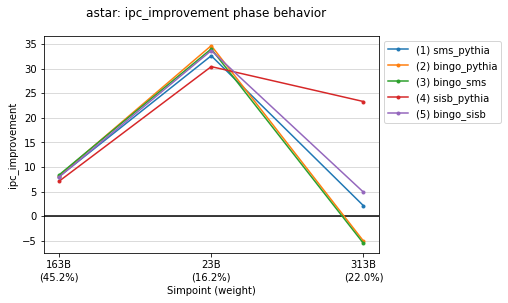

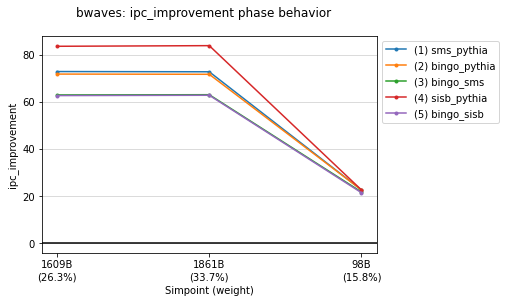

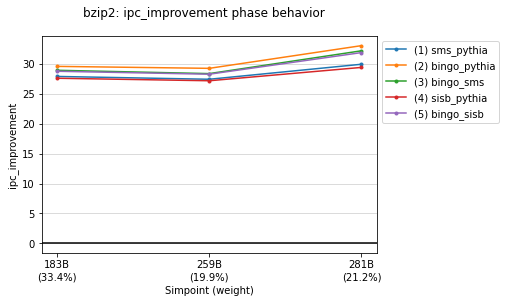

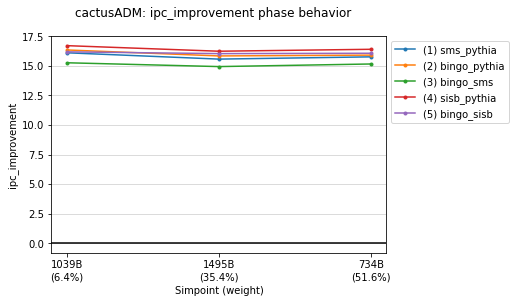

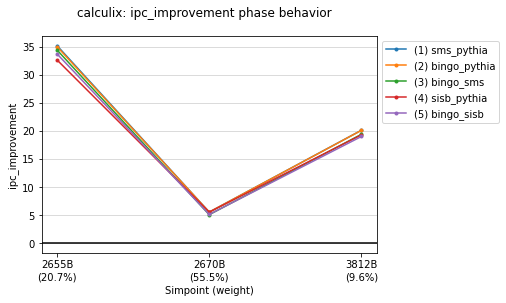

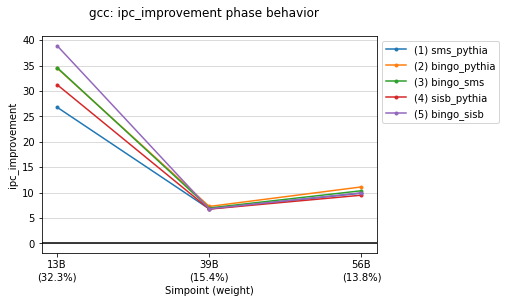

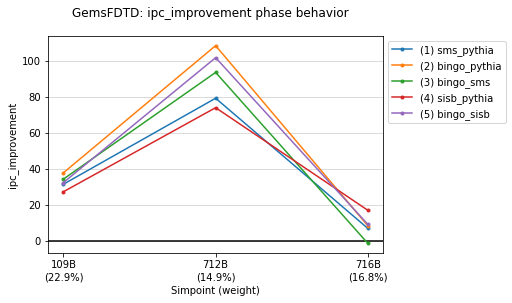

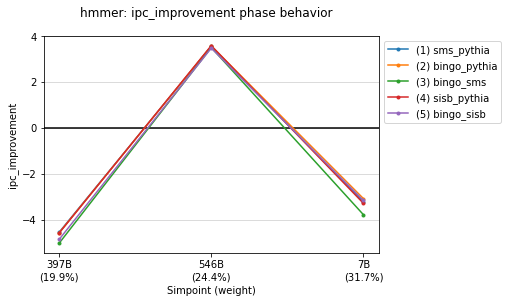

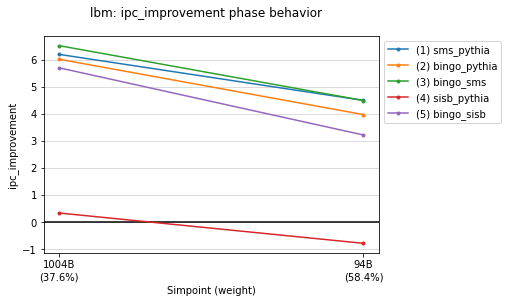

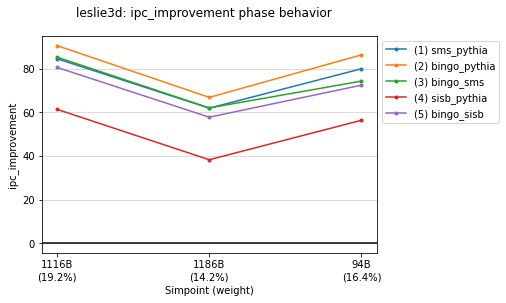

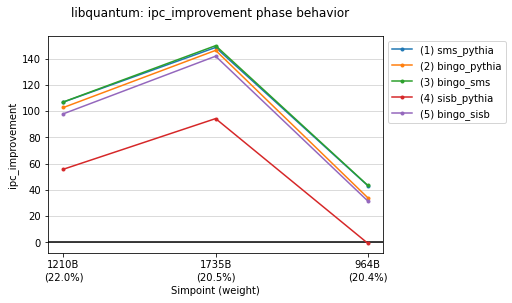

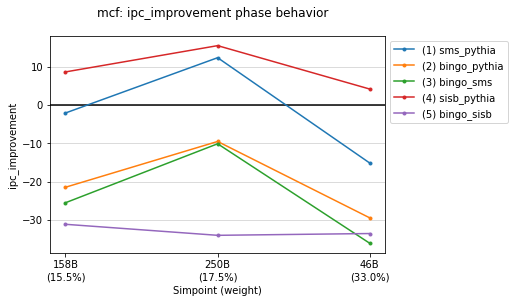

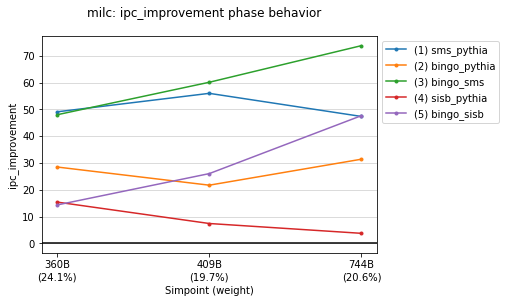

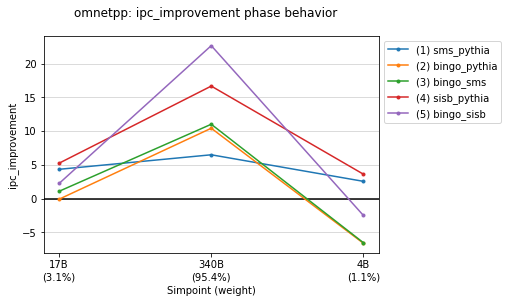

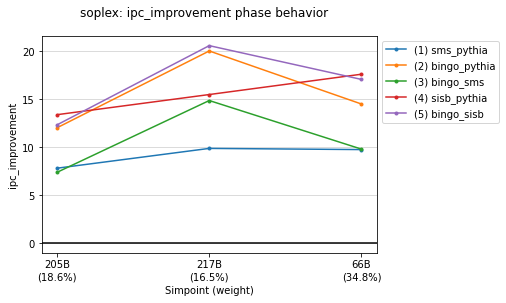

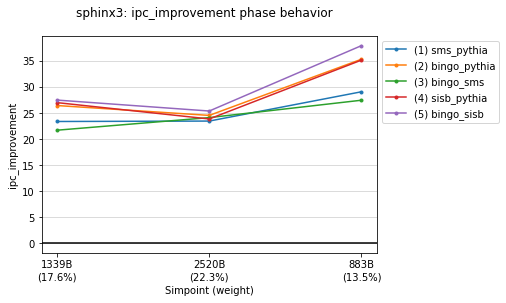

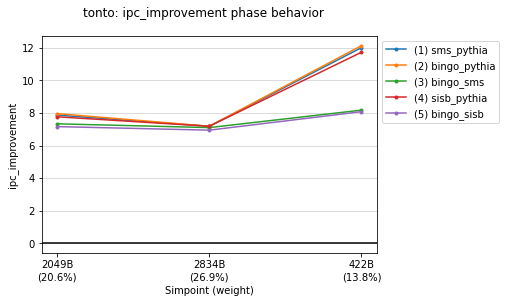

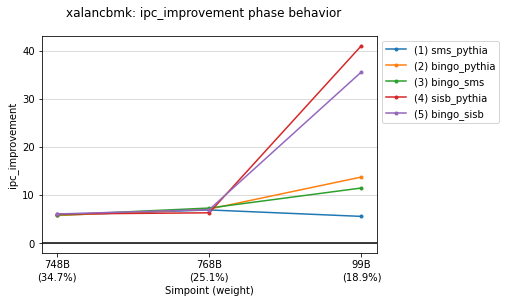

In [8]:
for tr in spec:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
    )

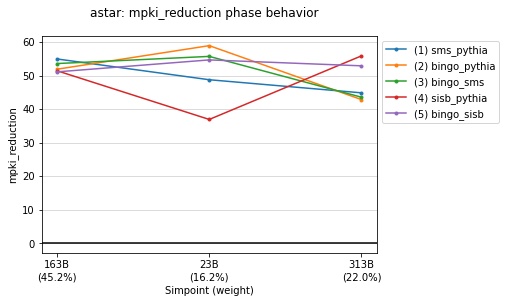

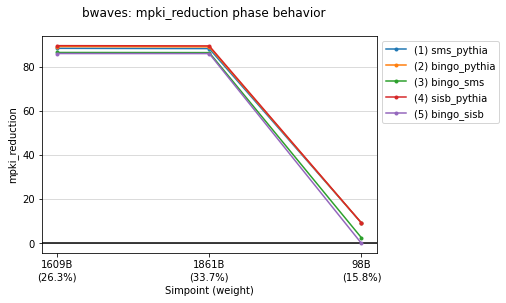

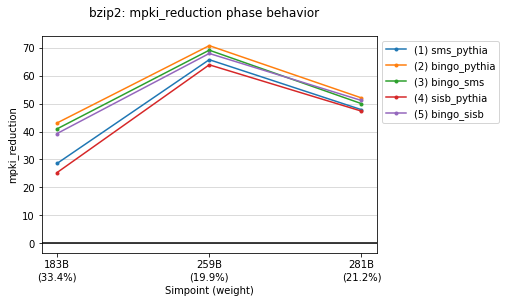

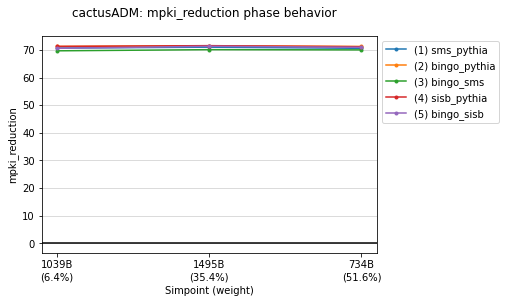

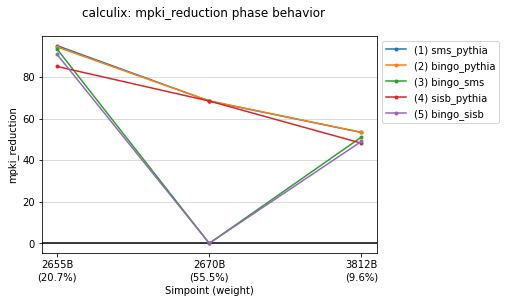

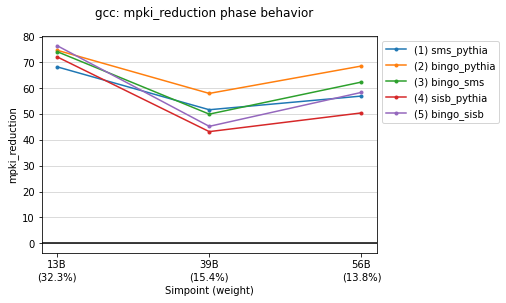

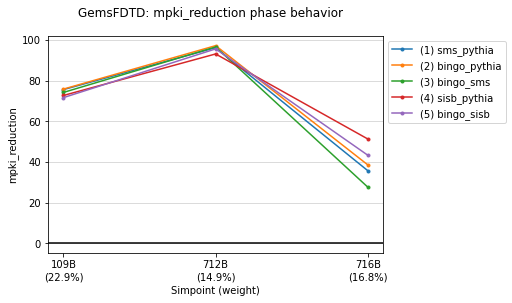

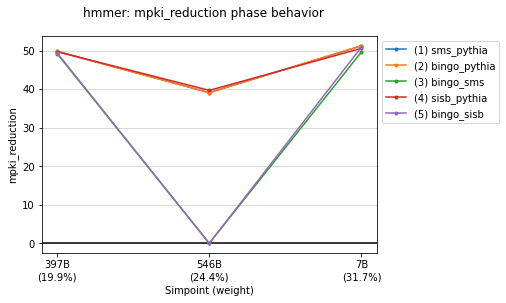

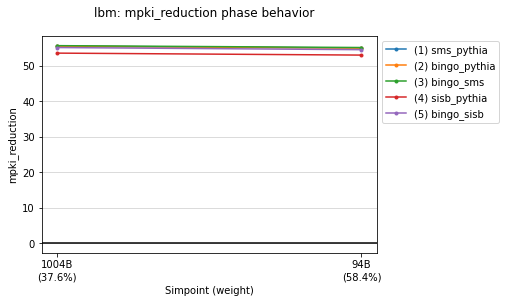

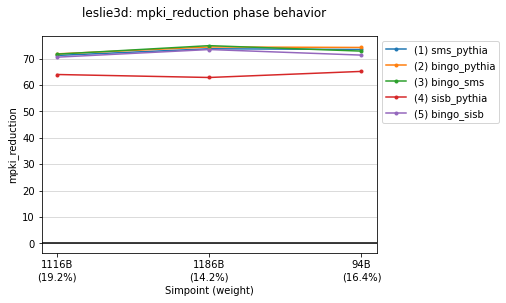

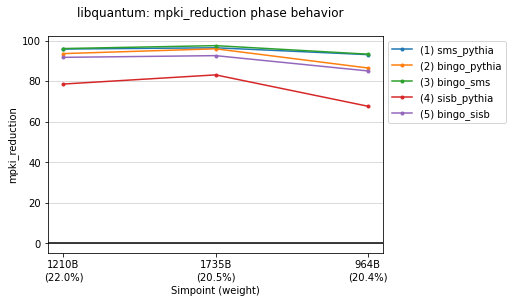

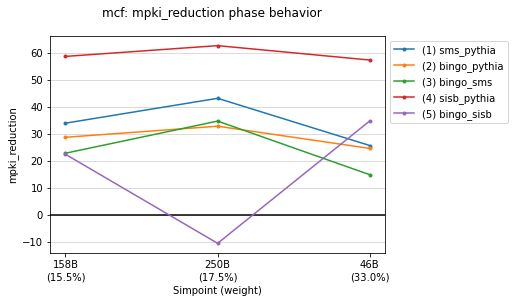

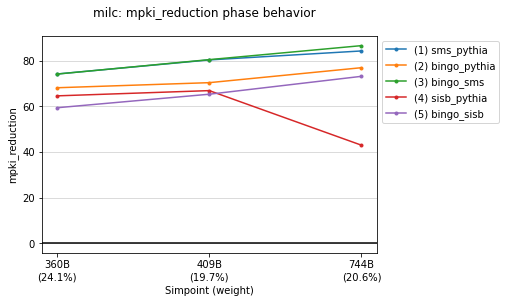

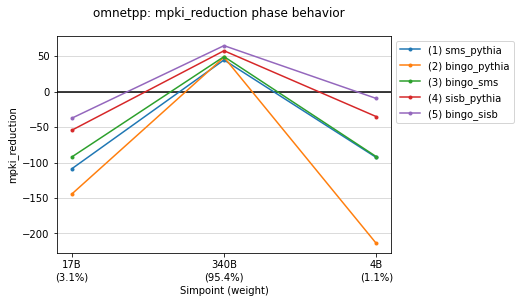

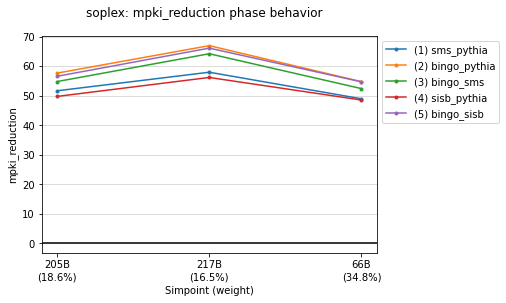

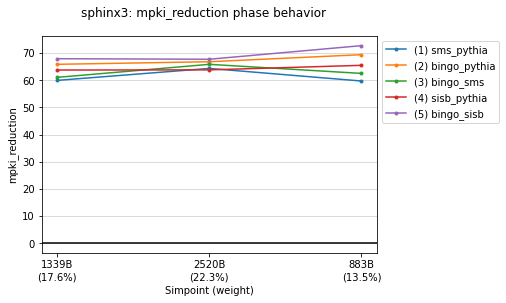

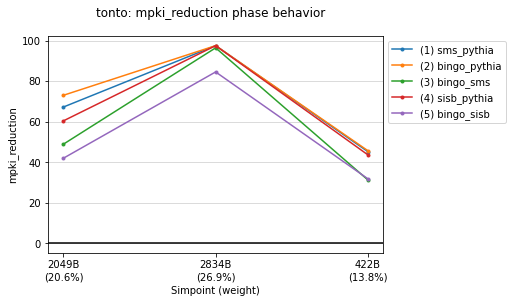

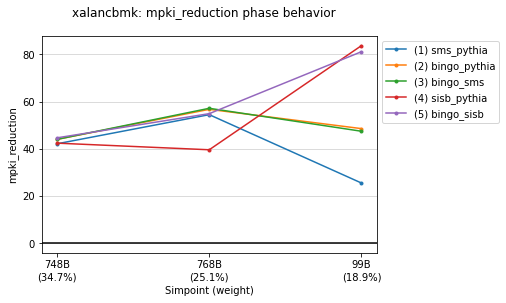

In [9]:
for tr in spec:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )

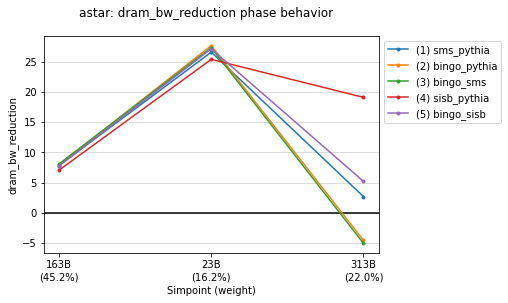

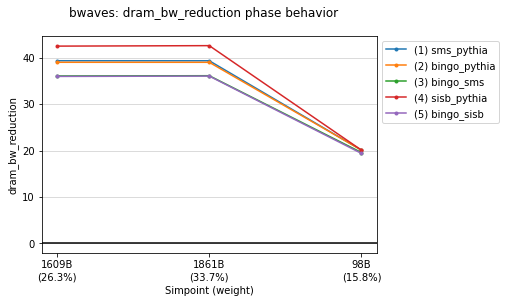

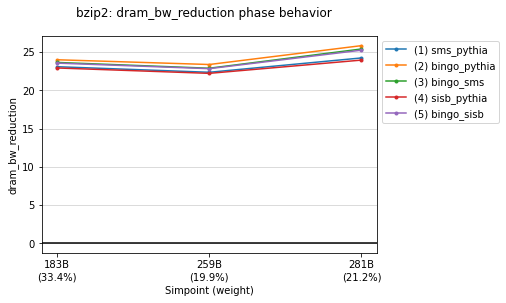

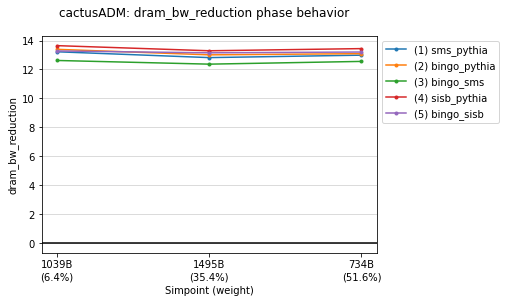

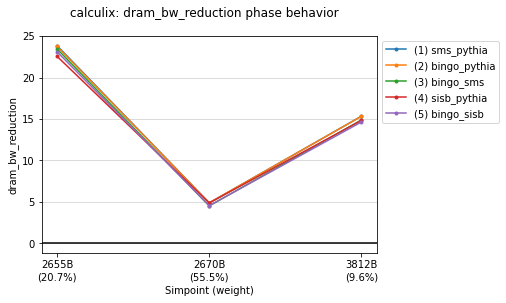

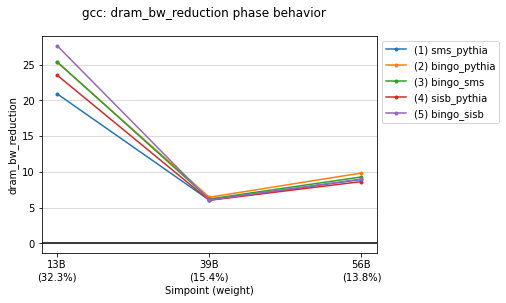

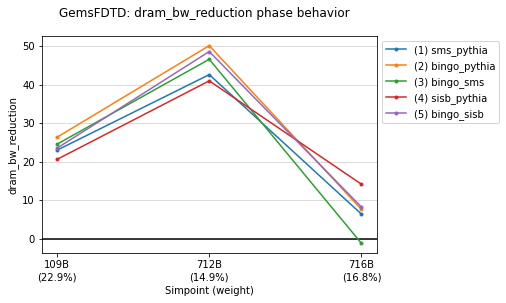

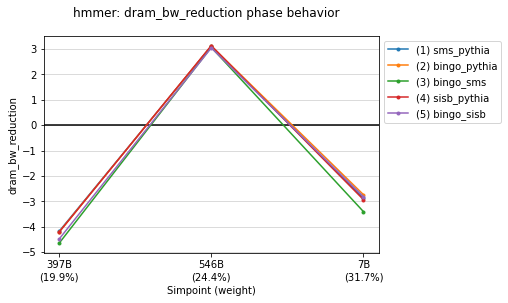

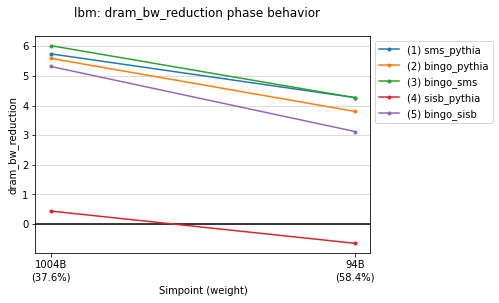

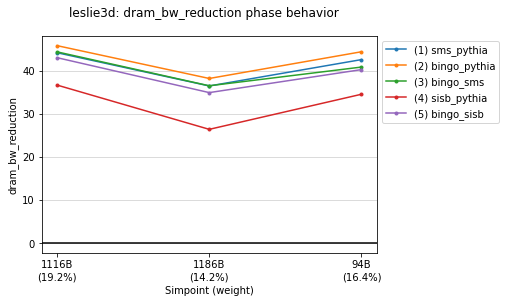

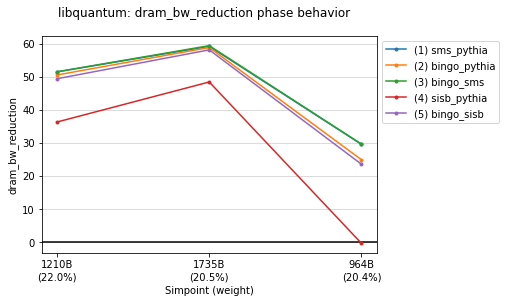

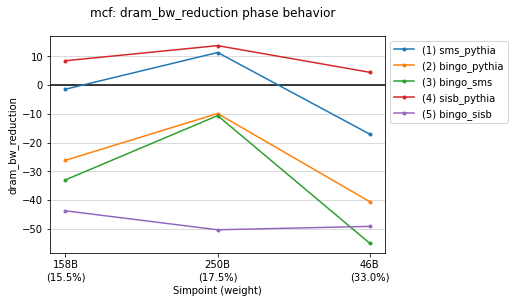

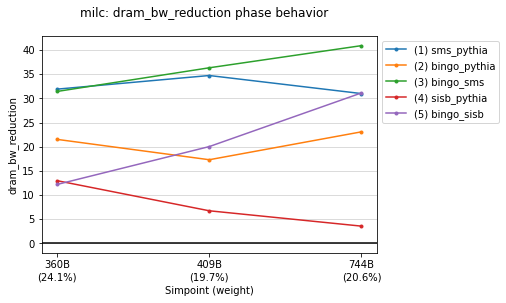

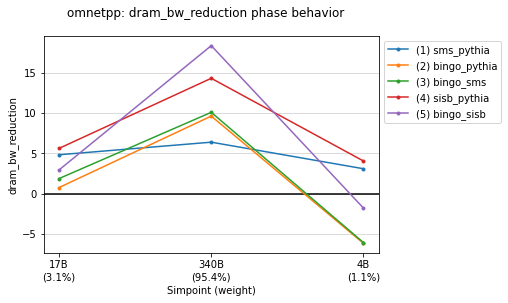

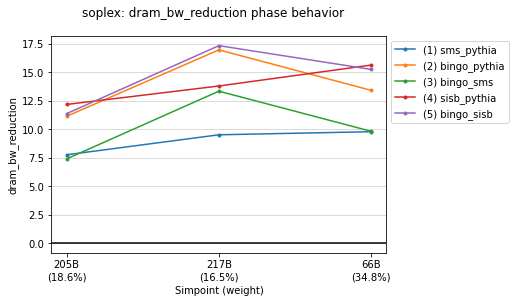

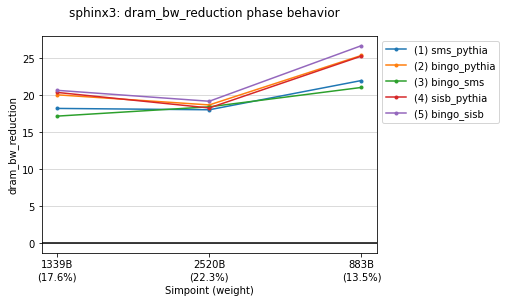

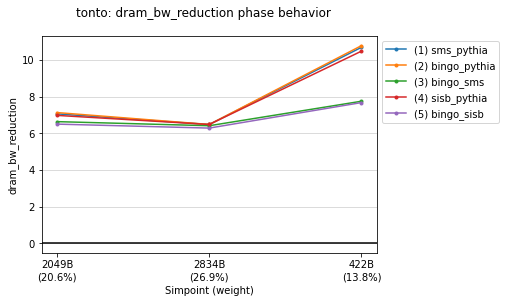

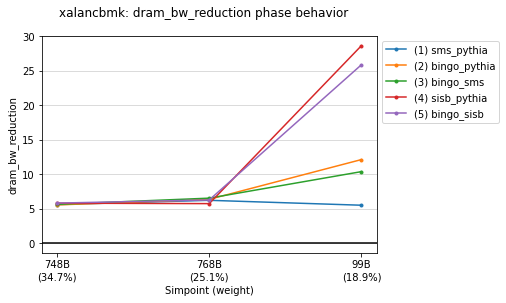

In [10]:
for tr in spec:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )

---
## Cloudsuite phase behavior
## Top 5

In [11]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(cloudsuite)], 'ipc_improvement', 5)
cs_top_5

['sisb_pythia', 'bingo_pythia', 'bingo_sisb', 'sms_pythia', 'bingo_spp']

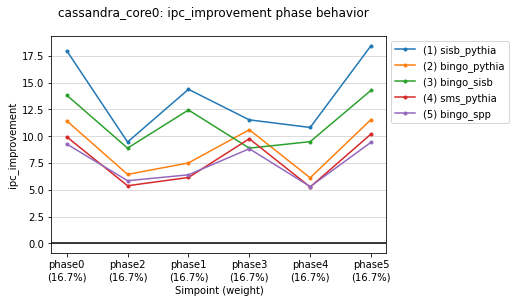

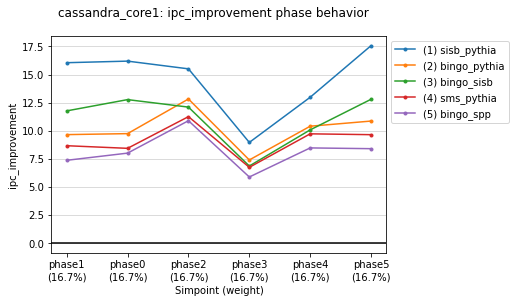

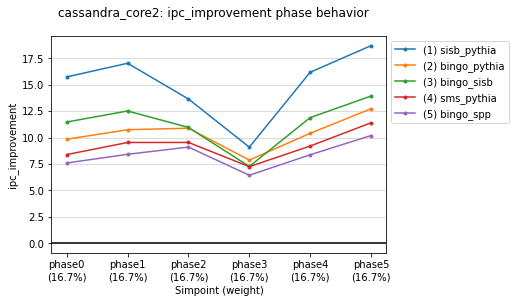

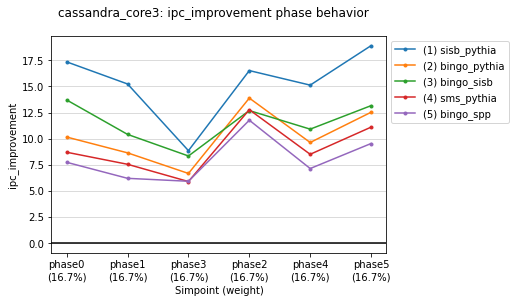

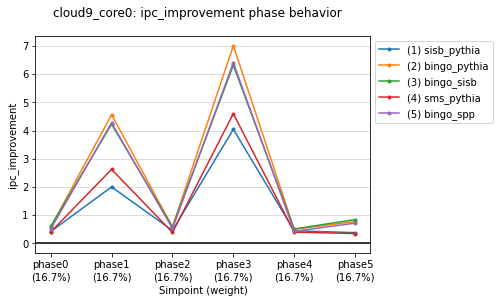

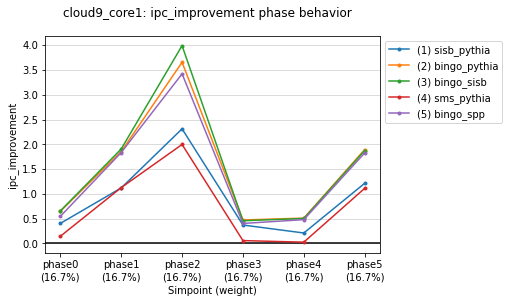

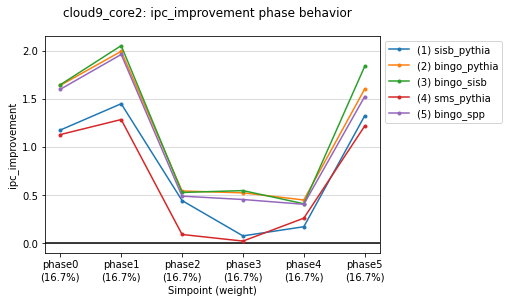

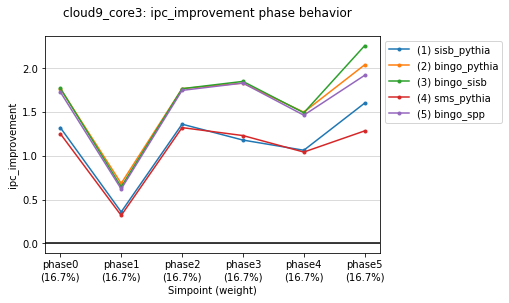

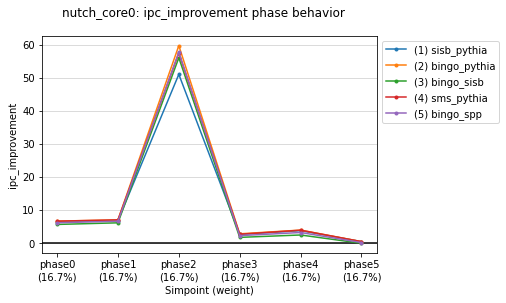

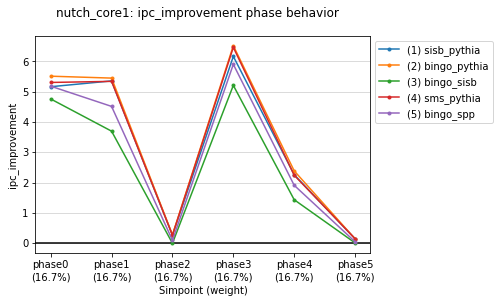

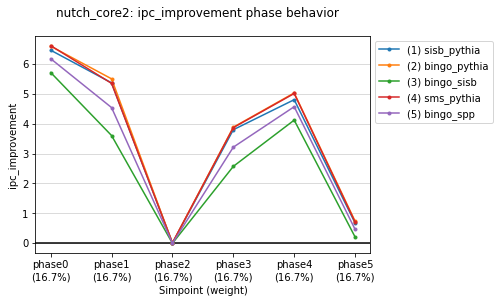

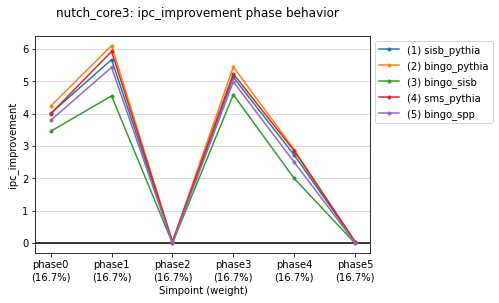

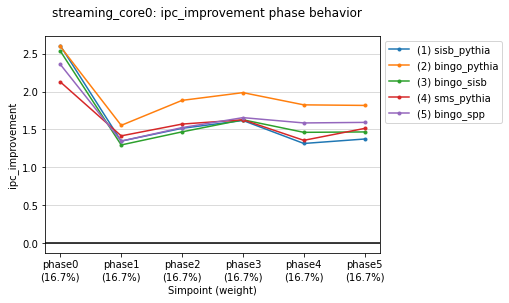

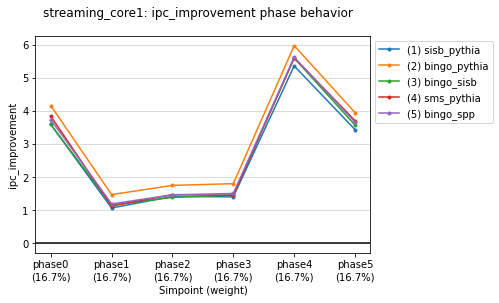

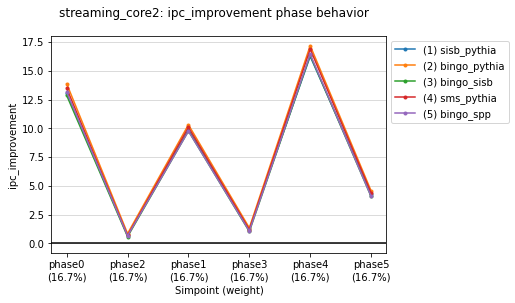

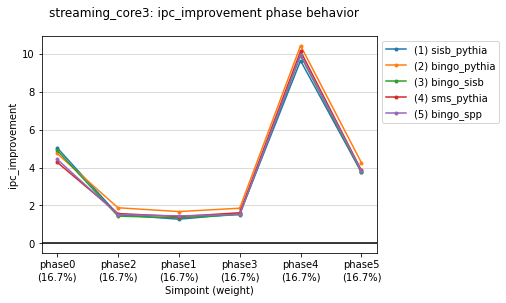

In [12]:
for tr in cloudsuite:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )

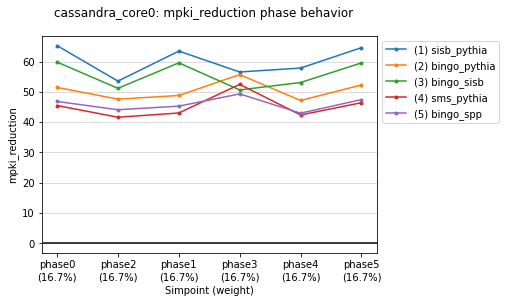

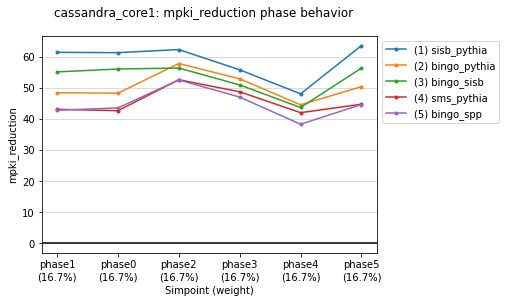

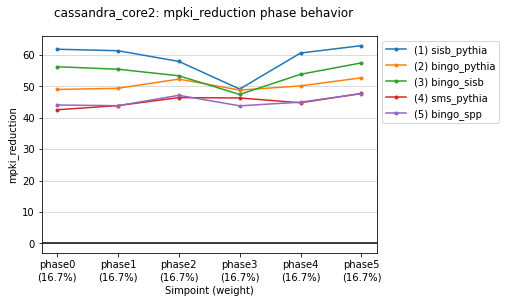

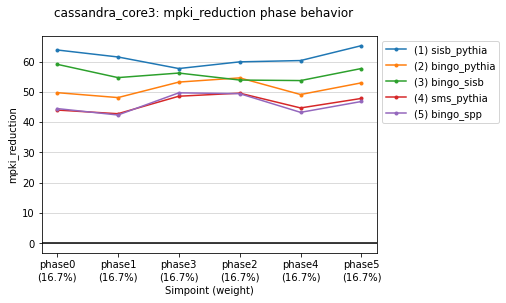

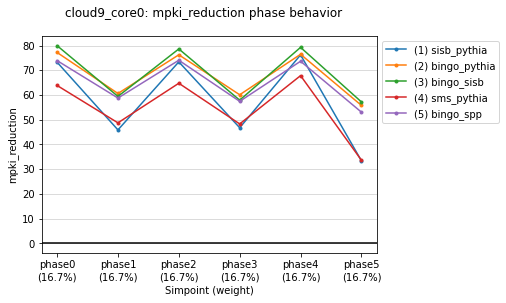

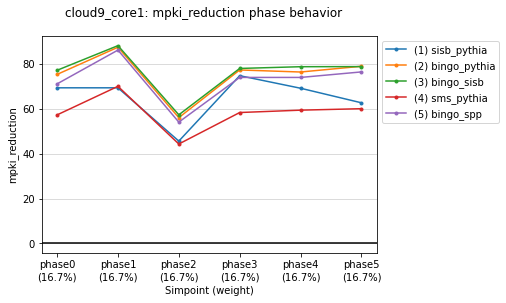

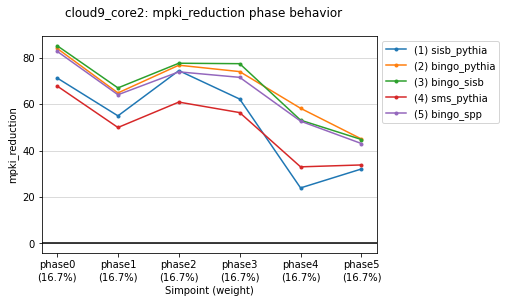

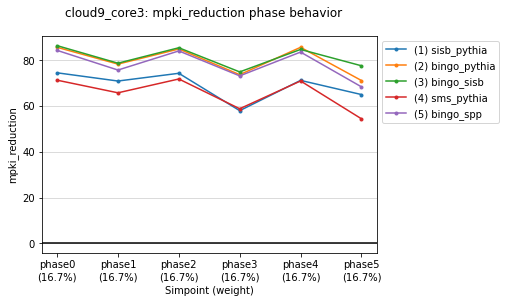

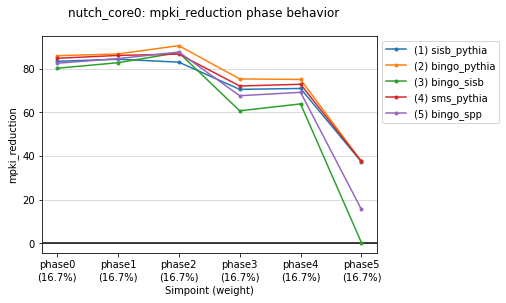

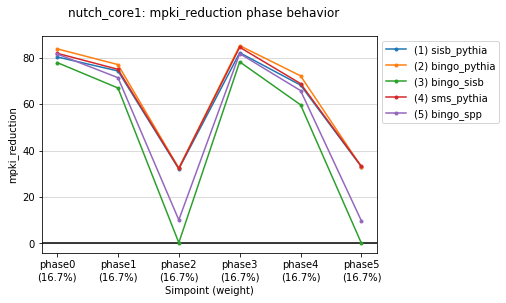

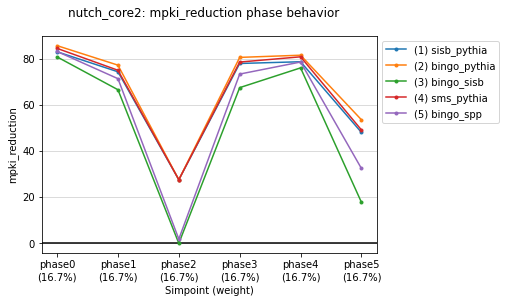

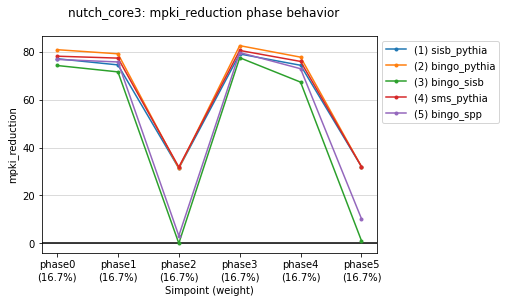

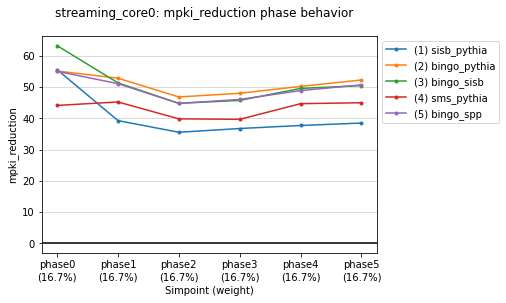

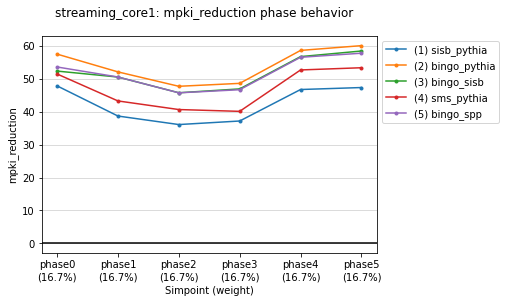

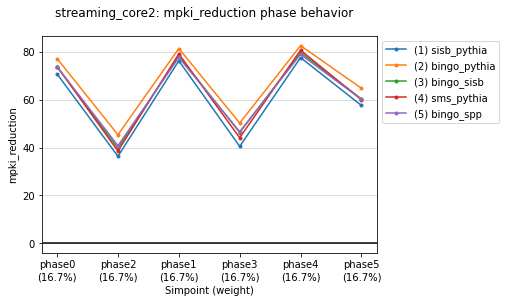

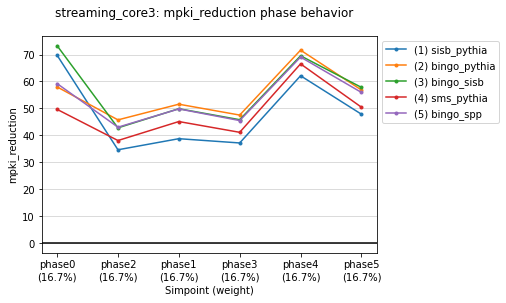

In [13]:
for tr in cloudsuite:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )

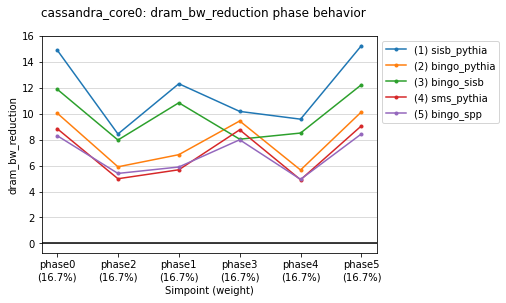

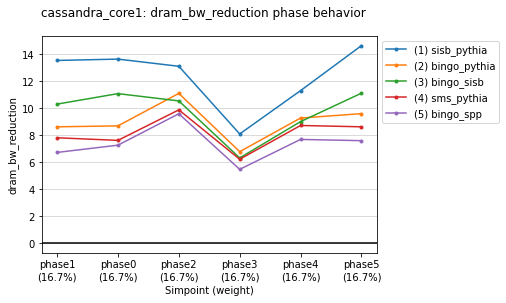

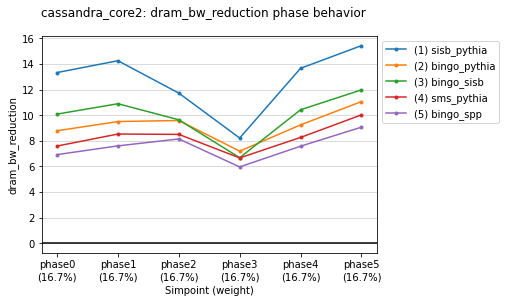

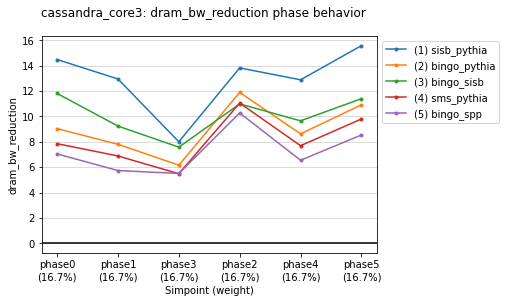

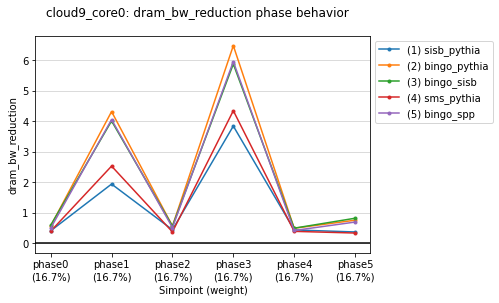

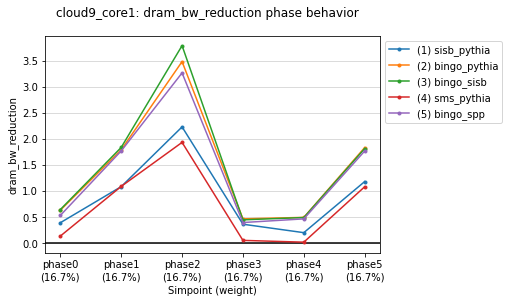

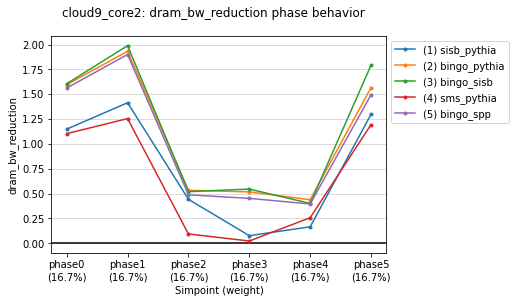

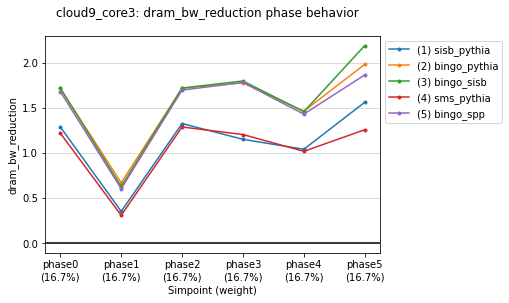

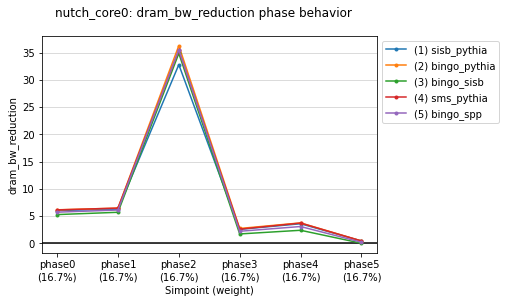

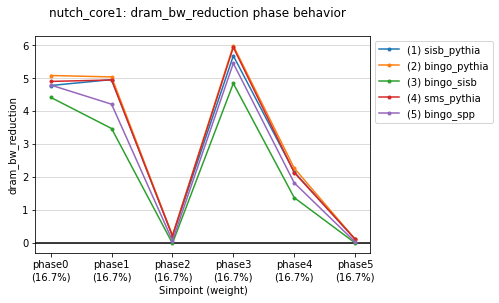

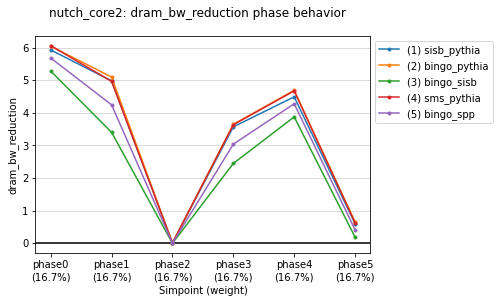

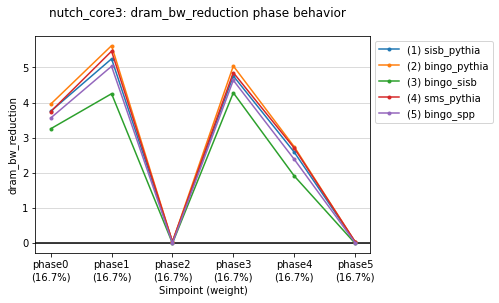

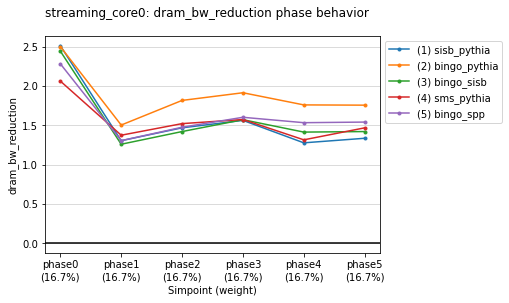

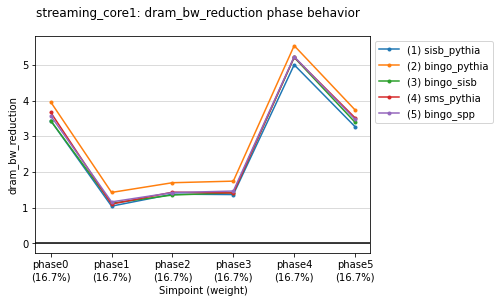

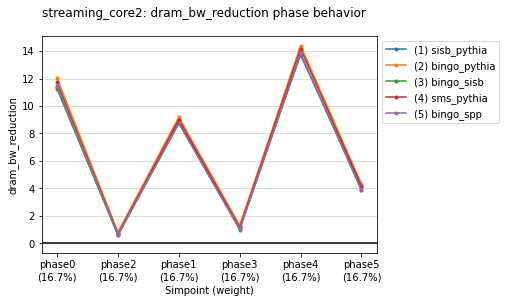

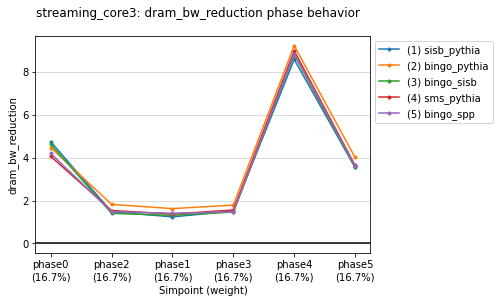

In [14]:
for tr in cloudsuite:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )